In [0]:
!wget --header="Host: www.manythings.org" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.113 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-IN,en;q=0.9,en-US;q=0.8,te;q=0.7" --header="Referer: https://colab.research.google.com/" --header="Cookie: __cfduid=dde45c9abac49727094edb9704ceb6c4a1587288097; __utma=3028652.767071753.1587288101.1587288101.1587288101.1; __utmz=3028652.1587288101.1.1.utmcsr=(direct)|utmccn=(direct)|utmcmd=(none)" --header="Connection: keep-alive" "http://www.manythings.org/anki/ita-eng.zip" -c -O 'ita-eng.zip'

In [2]:
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "ita-eng.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!')
del zip

File Name                                             Modified             Size
ita.txt                                        2020-03-15 02:17:06     47927476
_about.txt                                     2020-03-15 02:17:06         1441
Extracting all the files now...
Done!


In [0]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import os
import re
path=os.getcwd()+'/ita.txt'
# To read the file
import io
import numpy as np
# For normalizing data
import unicodedata
# Tensorflow libraries
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM,TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
# Metric that can tell the strength of relation between two sentences
import nltk.translate.bleu_score as bleu

In [0]:
K.clear_session()

In [0]:
# Converting into unicode --http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Function to convert into lower case, remove punctuation.
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s

In [0]:
# To open the file and read line by line
lines=io.open(path,encoding='UTF-8').read().split('\n')

In [0]:
# Raw data
lines[9010]

'Keep focused.\tRimanga concentrata.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2111647 (CK) & #5403202 (Guybrush88)'

In [0]:

def makedata(num_examples):
    '''
      The function will return eng - Ita sentences pairs
    '''
    ita_data=[]
    eng_data=[]
    eng_in=[]
    eng_out=[]
    for i in range(num_examples):
        
        eng,ita,_=lines[i].split('\t')
        
        # lines = 'Step back.\tFaccia un passo indietro.\tCC-BY 2.0 (France) Attribution: tatoeba.org #1553393 (CK) & #5282708 (Guybrush88)'
        # eng = Step back.
        # ita = Faccia un passo indietro.

        eng=normalize_string(eng)
        ita=normalize_string(ita)

        # For decoder input we will add start tag
        eng_in_='<start> '+eng
        # For decoder output we will add end tag
        eng_out_= eng + ' <end>'
        eng= '<start> ' +eng + ' <end>'
        ita_data.append(ita)
        eng_in.append(eng_in_)
        eng_out.append(eng_out_)
        eng_data.append(eng)
    
    return ita_data,eng_in,eng_out,eng_data




In [0]:
len(lines)

336615

In [0]:
num_examples=20000
ita_data,eng_in,eng_out,eng_data=makedata(num_examples)

In [17]:
print('Encoder  input:',ita_data[-1][:-1])
print('Decoder  input:',eng_in[-1][:-1])
print('Decoder output:', eng_in[-1][8:-1]+'<end>')

Encoder  input: ciao 
Decoder  input: <start> hi 
Decoder output: hi <end>


In [0]:
# Converting the text data to integer words

# Declare a tokenizer
ita_tokenizer=Tokenizer(filters='')
# Fit the tokenizer on Italy language pairs
ita_tokenizer.fit_on_texts(ita_data)
# inp_lan will have an integer represented for each word
inp_lan=ita_tokenizer.texts_to_sequences(ita_data)
# Pad sequences (By default it will pad zeros till the max length of the ita_data)
inp_lan=pad_sequences(inp_lan,padding='post')
# Here inp_lan is the encoder input data.

In [0]:
print('Encoder input Text data:',ita_data[9010])
print('Integer representation: ',inp_lan[9010])
print('Decoder input Text data:',eng_in[9010])
print('Integer representation: ',tar_lan_in[9010])
print('Decoder output Text data:',eng_out[9010])
print('Integer representation: ',tar_lan_out[9010])


In [0]:
# Declare the tokenizer for english words
eng_tokenizer=Tokenizer(filters='')
# we are fitting on eng_data not on eng_in or eng_out as it has both <start> and <end> tags
eng_tokenizer.fit_on_texts(eng_data)

In [0]:
# Decoder input data
tar_lan_in=eng_tokenizer.texts_to_sequences(eng_in)
tar_lan_in=pad_sequences(tar_lan_in,padding='post')

In [0]:
# Decoder output data
tar_lan_out=eng_tokenizer.texts_to_sequences(eng_out)
tar_lan_out=pad_sequences(tar_lan_out,padding='post')


In [0]:
# Max length of input_sequence, max_length of target sequence 
inp_seq_length=inp_lan[0].shape[0]
tar_seq_length=tar_lan_in[0].shape[0]

In [0]:
# Total number of unique words in Italian sentence 
ita_vocab_size=len(ita_tokenizer.word_index)+1
# Total number of unique words in english sentence
eng_vocab_size=len(eng_tokenizer.word_index)+1

In [0]:
# Max length of input_sequence, max_length of target sequence 
inp_seq_length=inp_lan[0].shape[0]
tar_seq_length=tar_lan_in[0].shape[0]

eng_index_word={}
eng_word_index={}
for key,value in eng_tokenizer.word_index.items():
  eng_index_word[value]=key 
  eng_word_index[key]=value



In [23]:
print('input lang in',inp_lan.shape)
print('target lang in',tar_lan_in.shape)
print('target lang out',tar_lan_out.shape)

# Total number of unique words in Italian sentence 
ita_vocab_size=len(ita_tokenizer.word_index)+1
# Total number of unique words in english sentence
eng_vocab_size=len(eng_tokenizer.word_index)+1

print('English vocab size',eng_vocab_size)
print('Italy vocab size',ita_vocab_size)
#print(ita_tokenizer_in.word_index)

input lang in (20000, 9)
target lang in (20000, 7)
target lang out (20000, 7)
English vocab size 2250
Italy vocab size 5524


### Building Model :

In [0]:
#Encoder input shape will be (Batch_size,inp_seq_length) --
input_encoder=Input(shape=(inp_seq_length,))

# Encoder LSTM needs the input to be 3 dim. One easy way to add a dimension to this integer sequences is to add a Embedding layer.

# input_encoder is passed to the embedding layer.  
encoder_embedding=Embedding(input_dim=ita_vocab_size,output_dim=128)(input_encoder)
# encoder_embedding shape is (Batch_size,inp_seq_length,output_dim) --
# Trainable paramters is ita_vocab_size * 128. 
# Each integer in the input_encoder is converted to 128 dimensional vector


encoder_lstm=LSTM(256,return_state=True)(encoder_embedding)
# Encoder_LSTM will return three arrays 
# 1. hidden_state/output of the last time step (None,256), 
# 2. hidden_state/ output of the last time step(None,256), 
# 2. cell_state of the last time step (None,256)


In [0]:
encoder_states=encoder_lstm[1:]
# Select the last two hidden states.

In [0]:
# Decoder input, we will keep the shape (None). Note: If none it can accept any size of data in dimension
# The reason we are not fixing the input_decoder to max_length is during 
# inference we will be sending only one input at a time step and predict. 

input_decoder = Input(shape=(None,))
# input_decoder shape is (None,None)

decoder_embedding_layer=Embedding(input_dim=eng_vocab_size,output_dim=128)
decoder_embedding_output=decoder_embedding_layer(input_decoder)
# decoder_embedding_layer - (None,None,128) 

decoder_lstm=LSTM(256,return_sequences=True,return_state=True)
decoder_output,_,_=decoder_lstm(decoder_embedding_output,initial_state=encoder_states)
# decoder_lstm will return three outputs
# 1. All the hiddenstate/output at each time step (None,None,256)
# 2. hiddenstate/output at last time step (None,256)
# 3. Cell state at last time step (None,256)


In [0]:
# Apply dense layer(units=eng_vocab_size) at every time step of the decoder_output
decoder_dense=TimeDistributed( Dense(eng_vocab_size,activation='softmax'))
dense_output= decoder_dense(decoder_output)
# dense_output shape (None,none, eng_vocab_size)


In [0]:
# Our model has two inputs, one to the encoder and other to the decoder. 
# outputs - Dense layer output
model=Model([input_encoder,input_decoder],dense_output)

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 9)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 9, 128)       707072      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    288000      input_2[0][0]                    
______________________________________________________________________________________________

In [31]:
# if input_decoder shape is (None,max_length)
# Dense output shape is (None,max_length,eng_vocab_size), decoder_output (None,max_length)
# Target data is just integers, while predicted data is a softmax output
# we apply sparse_categorical_crossentropy instead of categorical_crossentropy
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
# Train the model
model.fit([inp_lan, tar_lan_in], tar_lan_out,
          batch_size=64,
          epochs=10,
          validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 3s 12ms/step - loss: 2.4532 - val_loss: 2.5397
Epoch 2/10
250/250 [==============================] - 2s 10ms/step - loss: 1.7478 - val_loss: 2.3112
Epoch 3/10
250/250 [==============================] - 2s 10ms/step - loss: 1.4649 - val_loss: 2.1281
Epoch 4/10
250/250 [==============================] - 2s 10ms/step - loss: 1.3057 - val_loss: 2.0712
Epoch 5/10
250/250 [==============================] - 2s 10ms/step - loss: 1.1817 - val_loss: 2.0401
Epoch 6/10
250/250 [==============================] - 2s 10ms/step - loss: 1.0793 - val_loss: 1.9920
Epoch 7/10
250/250 [==============================] - 2s 10ms/step - loss: 0.9958 - val_loss: 1.9653
Epoch 8/10
250/250 [==============================] - 2s 10ms/step - loss: 0.9241 - val_loss: 1.9798
Epoch 9/10
250/250 [==============================] - 2s 10ms/step - loss: 0.8626 - val_loss: 1.9705
Epoch 10/10
250/250 [==============================] - 2s 10ms/step - loss: 0.8059 - val_lo

In [32]:
# Train the model
model.fit([inp_lan, tar_lan_in], tar_lan_out,
          batch_size=64,
          epochs=10,
          validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 2s 10ms/step - loss: 0.7556 - val_loss: 2.0020
Epoch 2/10
250/250 [==============================] - 2s 10ms/step - loss: 0.7058 - val_loss: 2.0044
Epoch 3/10
250/250 [==============================] - 2s 10ms/step - loss: 0.6606 - val_loss: 2.0303
Epoch 4/10
250/250 [==============================] - 2s 10ms/step - loss: 0.6198 - val_loss: 2.0382
Epoch 5/10
250/250 [==============================] - 2s 10ms/step - loss: 0.5797 - val_loss: 2.0392
Epoch 6/10
250/250 [==============================] - 2s 9ms/step - loss: 0.5456 - val_loss: 2.0836
Epoch 7/10
250/250 [==============================] - 2s 10ms/step - loss: 0.5092 - val_loss: 2.1024
Epoch 8/10
250/250 [==============================] - 2s 10ms/step - loss: 0.4808 - val_loss: 2.1048
Epoch 9/10
250/250 [==============================] - 2s 10ms/step - loss: 0.4546 - val_loss: 2.1533
Epoch 10/10
250/250 [==============================] - 2s 10ms/step - loss: 0.4275 - val_los

## Inference:


In [0]:
#Encoder model for inference
encoder_model=Model(input_encoder,encoder_lstm)
# encoder_model takes a integer sequence of Italian language as input and returns hidden_state and cell_state

In [34]:
#encoder_model.summary(line_length=200)
print(encoder_model.layers[1].weights[0][0][:10])
print(model.layers[2].weights[0][0][:10])

tf.Tensor(
[-0.01490658  0.16972525  0.07203316  0.01772093 -0.02092743 -0.02658156
  0.05521247  0.00849848  0.02269514  0.08476242], shape=(10,), dtype=float32)
tf.Tensor(
[-0.01490658  0.16972525  0.07203316  0.01772093 -0.02092743 -0.02658156
  0.05521247  0.00849848  0.02269514  0.08476242], shape=(10,), dtype=float32)


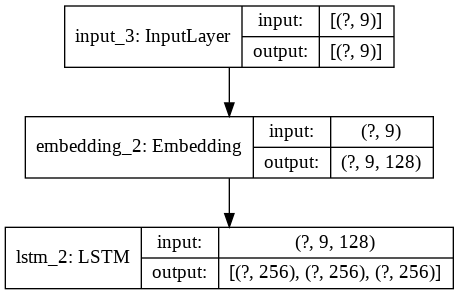

In [0]:
tf.keras.utils.plot_model(encoder_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
# Decoder states - shape is LSTM_Size
decoder_state_h=Input(shape=(256))
decoder_state_c=Input(shape=(256))
decoder_state_inputs=[decoder_state_h,decoder_state_c]

In [0]:
input_decoder.shape

TensorShape([None, None])

In [0]:
# Input to decoder is send to embedding layer
decoder_embedding_output=decoder_embedding_layer(input_decoder)

# Get the decoder outputs when a particular input and initial_state is given
decoder_outputs,state_h,state_c=decoder_lstm(decoder_embedding_output,initial_state=decoder_state_inputs)
decoder_states=[state_h,state_c]
# Send the decoder outputs to the dense layer to get the predicted word
decoder_outputs=decoder_dense(decoder_outputs)


In [0]:
# decoder model takes two inputs 1. Decoder input 2. Decoder initial states
# returns two outputs 1. Decoder outputs 2. decoder states(hidden_state and cell state)
decoder_model=Model([input_decoder]+decoder_state_inputs,[decoder_outputs]+decoder_states)

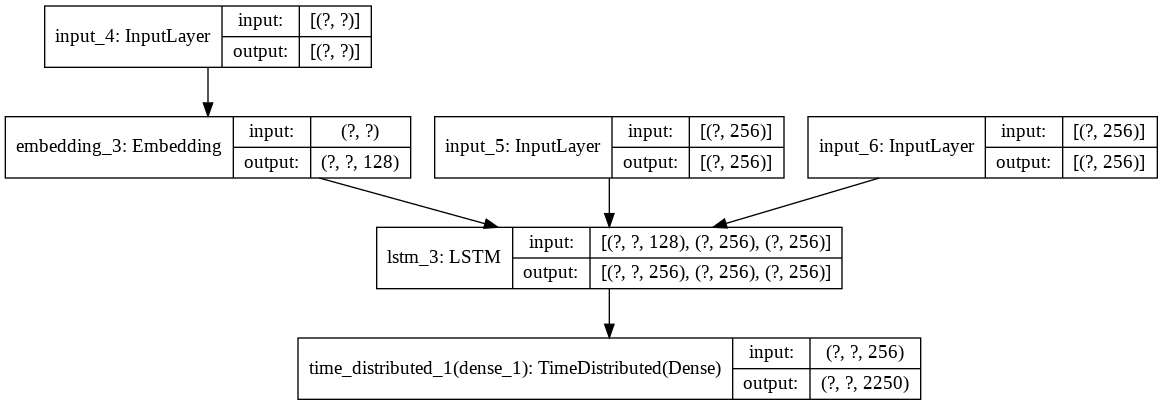

In [0]:
tf.keras.utils.plot_model(decoder_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [0]:
decoder_model.summary(line_length=150)

Model: "model_32"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_55 (InputLayer)                            [(None, None)]                   0                                                                   
______________________________________________________________________________________________________________________________________________________
embedding_26 (Embedding)                         multiple                         288000            input_55[0][0]                                    
______________________________________________________________________________________________________________________________________________________
input_62 (InputLayer)                            [(None, 256)]              

In [0]:
from prettytable import PrettyTable
import random    
x = PrettyTable()

In [0]:
x.field_names = ["Input data", "Actual data", "Predicted data"]

In [50]:
for i in range(10):
  index=random.randint(1,10000)
  pred=inference(inp_lan[index])
  x.add_row([ita_data[index],eng_out[index],pred])
  # print('Input data is: ',ita_data[index])
  # print('Actual data is: ',eng_out[index])
  # print('Predicted data is:',pred)
print(x)

+----------------------+----------------------+------------------------+
|      Input data      |     Actual data      |     Predicted data     |
+----------------------+----------------------+------------------------+
|    siete grassi ?    | are you fat ? <end>  |   are you fat ? <end>  |
|    sto ballando .    | i m dancing . <end>  |   i m dancing . <end>  |
|     stai calma .     |  stay calm . <end>   |    stay calm . <end>   |
|     tieni duro .     |  sit tight . <end>   |    sit tight . <end>   |
|   siate clementi .   | be merciful . <end>  |   be merciful . <end>  |
|   non ti muovere .   |  don t move . <end>  |  don t push it . <end> |
| fallo in ogni caso . | do it anyway . <end> |  do it monday . <end>  |
|    abbracci tom .    |   hug tom . <end>    |     keep up . <end>    |
| non essere timida .  | don t be shy . <end> |  don t be shy . <end>  |
|      usciamo !       | let s go out . <end> |    let s go . <end>    |
+----------------------+----------------------+----

In [0]:
def inference(seq):
  '''
    Function that takes Italian sequence and returns English sequence
  '''
  # Input the sequence to encoder_model and get the final timestep encoder_states(Hidden and cell state)
  seq=seq.reshape(-1,9)
  encoder_state_value=encoder_model.predict(seq)
  encoder_state_value=encoder_state_value[1:]
  # encoder_state_value[0] -- hidden_state -- shape (None,256)
  # encoder_state_value[1] -- cell_state -- shape (None,256)

  # Target word
  target_word=np.zeros((1,1))
  # <start>:1 , <end>:2 -- 
  target_word[0,0]=1
  
  stop_condition=False
  sent=''
  k=0
  while not stop_condition:

      # We are giving a target_word which represents <start> and encoder_states to the decoder_model
      output,state_h,state_c=decoder_model.predict([target_word]+encoder_state_value)
      # As the target word length is 1. We will only have one time step
      encoder_state_value=[state_h,state_c]
      # Output shape (1,eng_vocab_size). Find the word which the decoder predicted with max_probability
      output=np.argmax(output,-1)
      #print(output)
      # The output is a integer sequence, to get back the word. We use our lookup table reverse_dict
      sent=sent+' '+eng_index_word[int(output)]
      k+=1
      # If the max_length of the sequence is reached or the model predicted 2 (<end>) stop your model
      if k>5 or output==2:
        stop_condition=True
      target_word=output.reshape(1,1)
  
  return sent



